In [1]:
# Daniel Bandala @ apr 2022
import os,sys,time,random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ppmd import main as ppmd_compressor
from fast_ascent_algorithm import FAA,get_minimax_error,get_rms_error

# Eclectic Genetic Algorithm
An Eclectic Genetic Algorithm refers to an explicit algorithm which takes the best features out of all known computer genetics strategies, without regard for orthodoxy. In the EGA the methodology is incorporated as following:
- Full elitism over a set of size n of the last population.
- Deterministic selection scheme (as opposed to the traditional proportional selection operator).
- Annular crossover with rings of size L/2.
- Uniform mutation.

Full elitism refers that we keep a copy of the best $n$ individuals up to generation $k$. In other words, given that we have tested nk individuals by generation $k$, our population will consist of the best $n$ up to that point. Therefore, we artificially force the population to lean towards a focalized set of hyperplanes (A. Kuri, 2004). Traditionally, selection is based on fitness of the individuals, and in this way the individuals with greater fitness have a higher probability of being chosen for the crossover. In deterministic selection, also known as Vasconcelos, a strategy is imposed in which individuals with better fitness are crossed with those of worse fitness. This selection strategy no longer rely on the individual fitness to determine the most desirable descendants. Rather, we propose to emphasize genetic variety by imposing a crossover of predefined individuals. In this model we adopt the strategy of deterministically selecting individual i to cross it with individual n-i+1.

![alt text](images/algorithm.png "Deterministic selection and annular crossover")

In [22]:
def EGA(data_path,delimiter=',', max_degree=11, population_size=50, generations=36, crossover_probability=0.9, mutation_probability=0.05, cost_function='rms'):
    '''
    Funcion para estimar aleatoriamente posibles combinaciones de las potencias de los monomios de manera
    que el error minimax se minimice. Se realizan 'iterations' iteraciones, se halla el error maximo absoluto
    de cada modelo y se selecciona el que genere el menor error de todos estos.
    Inputs:
        data_path: str - Ruta del archivo a leer
        model_terms: int - numero de terminos para el modelo
        max_degree: int grado máximo de cada variable en cada monomio del modelo
        delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
        iterations: int - numero de posibles combinaciones a calcular
    Return:
        best_option: arreglo - tupla con un arreglo de los grados de cada monomio y otro arreglo 
        con los coeficientes correspondientes de los monios
    '''
    # get number of terms
    terms = NN_terms(data_path)
    # read data into pandas dataframe
    data = pd.read_csv(data_path,sep=delimiter,header=None)
    X = data.iloc[:,: data.shape[1]-1]
    y = data.iloc[:,data.shape[1]-1 :]
    variables = X.shape[1]
    # normalize data ??    
    # split data into training and validation sets
    train_data,test_data = train_test_split(data,random_state=1)
    train_data = train_data.to_numpy()
    test_data = test_data.to_numpy()
    # generate initial population
    T = InitialPopulation(terms,variables,max_degree,population_size)
    # trigger genetic process
    test_rms_errors = []
    test_mnmx_errors = []
    # eclectic genetic loop
    L_gen = int(terms/2)
    # initial evaluation and sorting
    T,_ = EvaluatePopulation(train_data,T,cost_function)
    for gen in range(generations):
        # duplicate first N individuals to lower set
        T_best = T[:population_size,:,:]
        T = np.r_[T,T_best]
        # deterministic crossover (annular crossover with L/2 rings)
        for i in range(int(T.shape[0]/2)):
            if random.uniform(0,1)>crossover_probability: continue
            # select best i-th and worst (n-i-1)-th individuals
            indiv_1 = T[i]
            indiv_2 = T[T.shape[0]-i-1]
            # annular crossover with semirings of size L/2
            locus = random.randint(0,L_gen)
            for j in range(locus,L_gen+locus):
                # get index in the semiring
                j_aux = j if j<terms else j-terms
                # swap genes in the position j_aux of each ring
                indiv_aux = indiv_1.copy()
                indiv_1[j_aux] = indiv_2[j_aux]
                indiv_2[j_aux] = indiv_aux[j_aux]
            # update genome population
            T[i] = indiv_1
            T[T.shape[0]-i-1] = indiv_2
        # uniform mutation
        for i in range(T.shape[0]):
            if random.uniform(0,1)<=mutation_probability:
                T[i][random.randint(0,terms-1)][random.randint(0,variables-1)] += random.randint(-1,1)        
        # evaluate all population individuals
        T,T_sol = EvaluatePopulation(train_data,T,cost_function)
        # get errors in both training and testing sets with best model in this generation
        error_minimax = get_minimax_error(test_data,T[0],T_sol[0])
        error_minimax2 = get_minimax_error(test_data,T[1],T_sol[1])
        error_minimax3 = get_minimax_error(test_data,T[2],T_sol[2])
        error_minimax4 = get_minimax_error(test_data,T[3],T_sol[3])
        error_minimax5 = get_minimax_error(test_data,T[4],T_sol[4])
        error_rms = get_rms_error(test_data,T[0],T_sol[0])
        error_rms2 = get_rms_error(test_data,T[1],T_sol[1])
        error_rms3 = get_rms_error(test_data,T[2],T_sol[2])
        error_rms4 = get_rms_error(test_data,T[3],T_sol[3])
        error_rms5 = get_rms_error(test_data,T[4],T_sol[4])
        print("Generation ",gen+1," -> Error RMS: ",error_rms," \t | \t Minimax error: ",error_minimax)
        test_rms_errors.append([error_rms,error_rms2,error_rms3,error_rms4,error_rms5])
        test_mnmx_errors.append([np.abs(error_minimax),np.abs(error_minimax2),np.abs(error_minimax3),np.abs(error_minimax4),np.abs(error_minimax5)])
        
    # get training and testing errors with best fitness model
    train_error_minimax = get_minimax_error(train_data,T[0],T_sol[0])
    train_error_rms = get_rms_error(train_data,T[0],T_sol[0])
    test_error_minimax = get_minimax_error(test_data,T[0],T_sol[0])
    test_error_rms = get_rms_error(test_data,T[0],T_sol[0])
    # print results
    print("\nEGA Performance Metrics")
    print("Train error (RMS)", train_error_rms," \t | \t Test error (RMS): ",test_error_rms)
    print("Train error (Minimax)", train_error_minimax," \t | \t Test error (Minimax): ",test_error_minimax)
    # plot fast ascent algorithm on best coefficient option found
    FAA(data.to_numpy(),coef_comb=T[0],save_results=False)
    # return best monomials powers and its corresponding coefficients along with best individuals error
    return T[0],T_sol[0],test_rms_errors,test_mnmx_errors

## Neural network trained to estimate best number of terms given a dataset

The first step was to set lower and upper practical limits on the number of terms. We reasoned that we were not interested in very small values for the polynomial terms. Very low values are hardly prone to yield good models. Therefore, we set a lower value of 3. On the other side of the spectrum we decided to focus on values less than 13. Higher values are seldom of
practical interest since large sets of coefficients are cumbersome and difficult to analyze. The polynomials terms are calculated with a neural network (Multilayer perceptron) as a function of the following parameters:
- Number of attributes
- Number of tuples
- Optimally encoded size
- Compression ratio

These attributes were selected from a much larger original subset of such attributes. The ones we selected were shown to be the more relevant from a Principal Components Analysis. Thereafter the mathematical model for the minimum number of terms as a function of the RMS error within the indicated limits may be calculated with this trained model.
![alt text](images/neural_network.png "Neural network used to estimate the number of polynomials terms")

In [4]:
def NN_terms(data_path,delimiter=',',min_terms=1,max_terms=13):
    ''' define neural network to estimate number of terms of the monomials for
        the polynomial optimization problem and approximation '''
    # read data
    data = pd.read_csv(data_path,sep=delimiter,header=None)
    # compress file with PPM algorithm
    ppmd_compressor([data_path])
    # get files size
    original_size = 0
    compressed_size = 0
    try:
        original_size = os.path.getsize(data_path)
        compressed_size = os.path.getsize(data_path+".ppmd")
        os.remove(data_path+".ppmd")
    except Exception as exc:
        print("Error reading data file information: ",exc)    
    
    # get dataset attributes
    bias = 1
    tuples = len(data.index)
    attributes = len(data.columns)
    compression_ratio = compressed_size/original_size if original_size>0 else 0
    # scale attributes
    tuples_min = 59.4135663696
    tuples_max = 3134.5324164552
    attributes_min = 1.356385937
    attributes_max = 36.25644988969
    comp_size_min = 5305.1795614531
    comp_size_max = 258920.293929573
    comp_ratio_min = 2.2681166805
    comp_ratio_max = 38.0070218056
    tuples = (tuples-tuples_min)/(tuples_max-tuples_min)
    attributes = (attributes-attributes_min)/(attributes_max-attributes_min)
    compressed_size = (compressed_size-comp_size_min)/(comp_size_max-comp_size_min)
    compression_ratio = (compression_ratio-comp_ratio_min)/(comp_ratio_max-comp_ratio_min)
    # first hidden percceptron weights
    w01 = 9.93878
    w11 = 12.794103
    w21 = -32.754846
    w31 = 1.290772
    w41 = 8.711606
    # second hidden perceptron weights
    w02 = -1.277238
    w12 = 2.149855
    w22 = 9.336392
    w32 = -8.214893
    w42 = -21.087847
    # output perceptron weights
    wo01 = -0.018833
    wo11 = 0.452167
    wo21 = 0.531239
    # calculate perceptrons inputs/outputs
    input_hn1 = bias*w01+tuples*w11+attributes*w21+compressed_size*w31+compression_ratio*w41
    hn1 = 1/(1+np.exp(-input_hn1))
    input_hn2 = bias*w02+tuples*w12+attributes*w22+compressed_size*w32+compression_ratio*w42
    hn2 = 1/(1+np.exp(-input_hn2))
    input_on = bias*wo01+hn1*wo11+hn2*wo21
    nn_output = 1/(1+np.exp(-input_on))
    # truncate neural network output, we need an integer not a real number
    terms = int(nn_output*(max_terms-min_terms)+min_terms)
    return terms

## Initial population generation function
Function that generates the initial set of candidate polynomials which will define the behavior of the algrotithm's search. It is therefore, of utmost importance that the powers of the
individuals belong to $L$ while, simultaneously, representing an unbiased sample of $L$ elements. In the EGA this is achieved by randomly sampling $L$ where every sample belongs to a normal distribution with $\mu \in L$. Note that each individual contains the previous estimated number of terms and each of these contains a list of the powers of the independent variables. Thus, the population array has the form $R^{size X terms X variables}$. An example of a random individual for 6 terms and 4 variables is the following
$$I = \begin{pmatrix}
1 & 0 & 2 & 0\\
0 & 0 & 0 & 0\\
0 & 2 & 1 & 0\\
1 & 1 & 2 & 1\\
0 & 0 & 2 & 5\\
2 & 3 & 2 & 0
\end{pmatrix}$$
where the sum of the powers of each variable for each term, every row, must exist in $L$ 

In [9]:
def InitialPopulation(terms=6, variables=4, max_degree=11,population_size=50):
    ''' Generate initial population with posible combinations
        for the powers of each monomial
    INPUTS
        terms: number of tearms for each individual
        population_size: number of individuals to generate
        max_degree: max degree for each variable in the monomials
    OUTPUT
        T: numpy array of individuals with distinct genome '''
    T = []
    # powers of coefficients for polynomial multivariate approximation
    # based on cybenkos and weierstrass theorems
    L_or = [0,1,3,5,7,9,11,15,21,25,27,33,35,45,49,55,63,77,81,99,121]
    L = []
    # get the subset with atmost max_degree values
    for i in range(len(L_or)):
        if L_or[i]>max_degree: break
        L.append(L_or[i])
    # generate population with 'terms' number of genes
    for ind in range(population_size):
        L_len = len(L)
        individual = np.zeros((terms,variables))
        for i in range(terms):
            l = L[random.randint(0,L_len-1)]
            idx_sec = [k for k in range(variables)]
            random.shuffle(idx_sec)
            for j in idx_sec:
                var_degree = random.randint(0,l)
                individual[i][j] = var_degree if j!=idx_sec[len(idx_sec)-1] else l
                l = l - var_degree
        T.append(individual)
    return np.array(T)

## Evaluate population fitness
The solution associated with each of the genomes are calculated applying the fast ascent algorithm. These solutions and fitness errors (Root square median error and minimax error) are stored in table $T\_sol$. Then, the whole population is sorted in descending fitness error.

In [16]:
def EvaluatePopulation(train_data,T,cost_function='rms'):
    ''' Evaluate population individuals with ascent algorithm and
        return sorted solutions with respect of cost function 
    INPUTS:
        train_data: numpy array with training data
        T: individuals population genome
        cost_function: string with cost function name (rms,minimax)
    OUTPUTS:
        T: sorted individuals with cost function
        T_sol: sorted solutions 
    '''
    # initialize solution arrays
    T_sol = []
    rms_errors = []
    minmax_errors = []
    for i in range(T.shape[0]):
        # fit data with fast ascend algorithm
        sol,e_rms = FAA(train_data,coef_comb=T[i],save_results=False,verbose=False)
        # assign errors and penalty to non-compliant monomials powers
        e_rms,e_mnmx = RepairGenome(T[i],e_rms,sol[0])
        rms_errors.append(e_rms)
        minmax_errors.append(e_mnmx)
        # append solution to vector
        T_sol.append(sol[1:])
    T_sol = np.array(T_sol)
    # take and sort individuals by fitness in descending order
    sorting = np.array(minmax_errors).argsort() if cost_function=='minimax' else np.array(rms_errors).argsort()
    T = T[sorting]
    T_sol = T_sol[sorting]
    # return sorted solution
    return T,T_sol

## Repair non-compliant random mutation
After make all corresponding mutations in current population it will be some cases where the resulting genome is non-compliant with the model initial restrictions. In this case, this restriction is that the sum of all powers of the variables in each term must be in the list $L$ (Obtained with Cybenkos and Weierstras theorems). In the case we find a non-compliant individual this function add a penalty factor on its corresponding cost function. This factor must be a huge number in order to force the algorithm to give low influence from these genes in the next generation.

In [17]:
def RepairGenome(individual,error1,error2,penalty=1e6):
    ''' Get current population with random mutation (using mutation_probability)
        and repair individuals with non-compliant models restrictions assigning
        a penalty into its cost function 
    INPUTS:
        individual: genome of the individual to be evaluated
        error1,error2: errors where to add the penalty
        penalty: constant of penalization
    OUTPUTS:
        errors with its penalty value if needed
    '''
    L = [0,1,3,5,7,9,11,15,21,25,27,33,35,45,49,55,63,77,81,99,121]
    for i in range(individual.shape[0]):
        if np.sum(individual[i]) not in L:
            return error1+penalty,error2+penalty
    return error1,error2

## Test algorithm with a given dataset
The implemented algorithm is executed with the following parameters
- data_set = dataset.csv
- max_degree=11
- population_size=40
- generations=16
- crossover_probability=0.9
- mutation_probability=0.05
- cost_function='rms'

Generation  1  -> Error RMS:  0.015343181117555999  	 | 	 Minimax error:  0.03767811666139673
Generation  2  -> Error RMS:  0.014486730707814085  	 | 	 Minimax error:  0.03603297916503326
Generation  3  -> Error RMS:  0.012260643608599875  	 | 	 Minimax error:  0.021628526366982953
Generation  4  -> Error RMS:  0.0011316522819143915  	 | 	 Minimax error:  0.0022944197337254335
Generation  5  -> Error RMS:  0.001015567312364479  	 | 	 Minimax error:  0.0017098157101430034
Generation  6  -> Error RMS:  1.1809035654142261e-07  	 | 	 Minimax error:  1.7256356088513058e-07
Generation  7  -> Error RMS:  1.1767231019645945e-07  	 | 	 Minimax error:  1.506463112033174e-07
Generation  8  -> Error RMS:  1.1203454539197798e-07  	 | 	 Minimax error:  1.517629004132992e-07
Generation  9  -> Error RMS:  1.1598667363997982e-07  	 | 	 Minimax error:  1.4574084958307587e-07
Generation  10  -> Error RMS:  1.1369243893654559e-07  	 | 	 Minimax error:  1.4655361951776413e-07
Generation  11  -> Error RMS: 

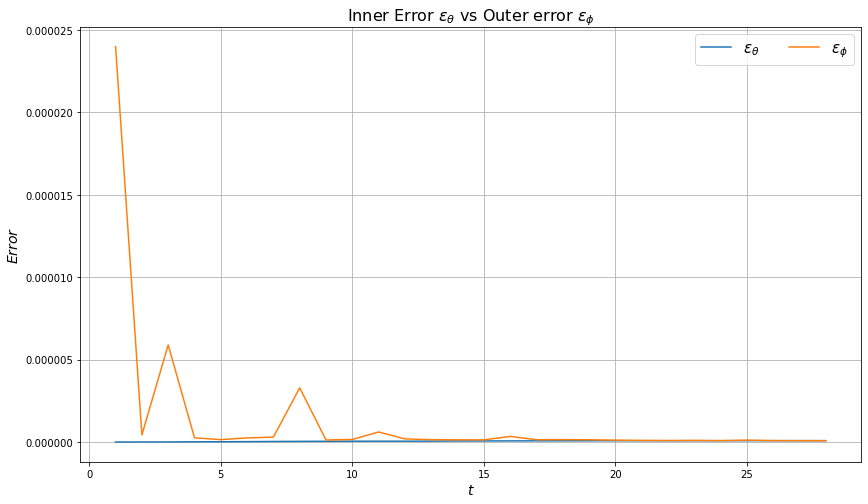

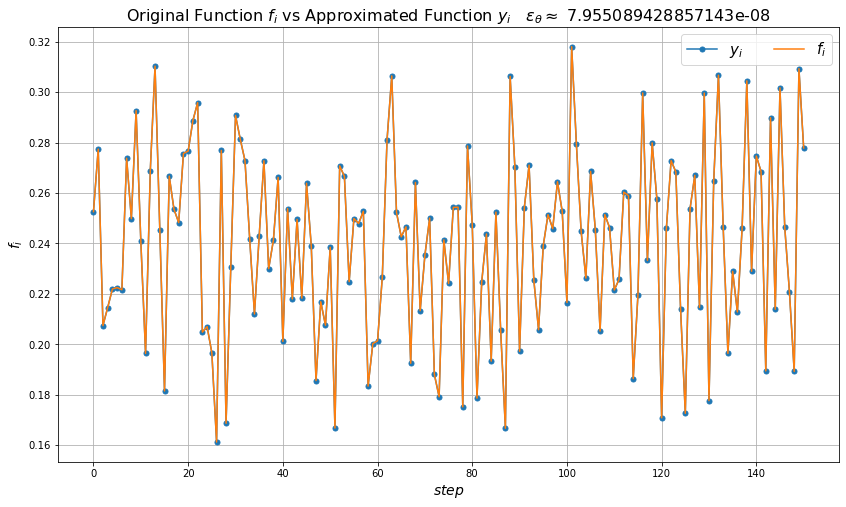


*** RESULTS ***
E_minimax: 	0.0000000796 
C[ 1]	 -0.0016345623 
C[ 2]	 -0.0000000277 
C[ 3]	 0.1084589949 
C[ 4]	 -0.0000002713 
C[ 5]	 0.0637904277 
C[ 6]	 0.0059903543 
C[ 7]	 0.0684299396 
C[ 8]	 0.0681212783 
C[ 9]	 0.0314965751 

Execution time 	0.0144507885 s 
In the Results File the following will be written:
a) The coefficients the minimax error
b) Approximation and Original data



In [23]:
mon_degrees,mon_coeffs,rms_errors,mnmx_errors = EGA("dataset.csv",population_size=40,generations=16)

In [24]:
mon_degrees

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 4., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 2., 4., 2., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [25]:
mon_coeffs

array([ 6.61802484e-03,  1.73757677e-08,  8.24860603e-02,  3.98416368e-07,
        6.37904516e-02, -2.26223108e-03,  6.84300153e-02,  6.81212249e-02,
        5.74694689e-02])

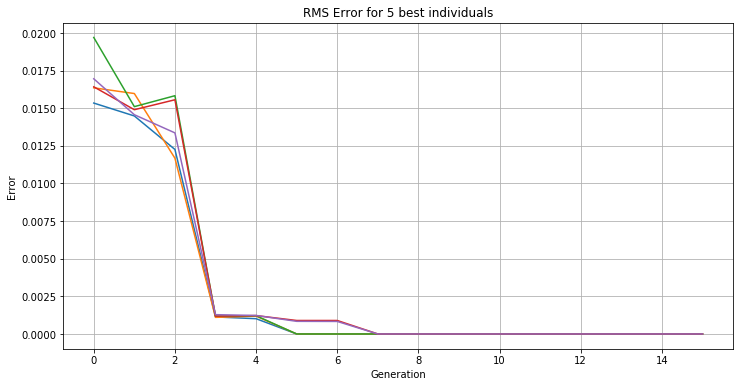

In [29]:
plt.figure(figsize=(12,6))
plt.plot(rms_errors)
plt.title("RMS Error for 5 best individuals")
plt.ylabel("Error")
plt.xlabel("Generation")
plt.grid()

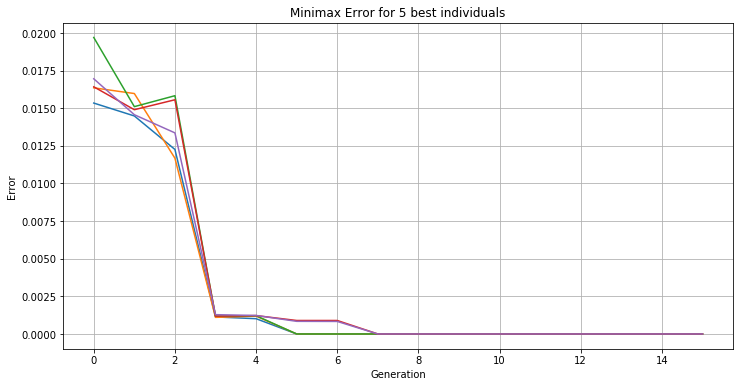

In [30]:
plt.figure(figsize=(12,6))
plt.plot(rms_errors)
plt.title("Minimax Error for 5 best individuals")
plt.ylabel("Error")
plt.xlabel("Generation")
plt.grid()